# Experiment Results
This experiment was performed using the best parameters that maximized f1-macro.  

Use results from `notebooks/cometML/f1macro_results` directory.(result from cometML project `handai-gencat-5`)  
We will visualize the following four experiments.

* Heterophily & Homophily Experiment
* Attribute Experiment
* Scalability Experiment
    * Node & Edge Experiment       
* Class size Experiment

Note that the results of the node & edge experiment were obtained when the parameters were adjusted only for `GenCAT_cora_6000_10000_2` dataset.

In [27]:
import os
import sys
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append("../../")

path_result = "../cometML/f1macro_results/"


In [28]:
from scripts.utils import load_data
from scripts.utils_gencat import  feature_extraction

In [29]:

def plot_result(dataframe, methods, x_list, base_dataset, labels: list , metric="test_acc"):
  plt.rcParams['text.usetex'] = True
  plt.style.use('default')
  sns.set()
  sns.set_style('whitegrid')
  sns.set_palette('Set1')

  fig = plt.figure(figsize=(8, 5))
  ax = fig.add_subplot(1, 1, 1)
  markers = ['o', 'v', 'x', 'D',".", "^", "<", ">", "p", "*"]
  markers = markers + markers
  colors = plt.cm.get_cmap("tab20").colors

  for i, method in enumerate(methods):
    tmp = dataframe[dataframe["net"] == method]
    # tmp = tmp[tmp["dataset"]==f"GenCAT_cora_{x[i]}_0"]
    # 集約→datasetのiter部分を集計 GenCAT_{dataset}_{para}_{iter}
    # print(method,tmp.shape)
    test_acc_mean_list, test_acc_std_list = [],[]
    for x in x_list:
      tmp_filtered = tmp[tmp["dataset"].str.contains(f"GenCAT_{base_dataset}_{x}")]
      if len(tmp_filtered)>0:
        test_acc_mean = (tmp_filtered[f"{metric}_mean"] *
            tmp_filtered["RPMAX"].astype(int)).sum() / (len(tmp_filtered) * tmp_filtered.head(1)["RPMAX"].astype(int).values[0])
        test_acc_std = (tmp_filtered[f"{metric}_std"] *
                    tmp_filtered["RPMAX"].astype(int)).sum() / (len(tmp_filtered) * tmp_filtered.head(1)["RPMAX"].astype(int).values[0])
      else:
        test_acc_mean = np.nan
        test_acc_std = np.nan
      test_acc_mean_list.append(test_acc_mean)
      test_acc_std_list.append(test_acc_std)
    # print(method, test_acc_std_list)
    ax.errorbar(
        x_list,
        test_acc_mean_list,
        yerr=test_acc_std_list,
        marker=markers[i],
        label=method,
        capthick=1,
        capsize=8,
        lw=1,
        color=colors[i])
  ax.set_xlabel(labels[0])
  ax.set_ylabel(labels[1])
  ax.legend(ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.show()


# Heterophily & Homophily Experiment

In [30]:
exp = "hetero_homo"
split = "supervised"
result_path = f"{path_result}result_{exp}_{split}5.csv"

df_hetero_homo = pd.read_csv(result_path)
print(df_hetero_homo.shape)
df_hetero_homo.head()[["dataset", "net", "test_acc_mean", "test_acc_std", "date"]]


(255, 63)


,dataset,net,test_acc_mean,test_acc_std,date
0,GenCAT_cora_8_2,GCN,30.630631,0.920940,2022-06-02 18:19:05.892
1,GenCAT_cora_8_1,GCN,27.476738,3.184967,2022-06-02 18:18:54.462
2,GenCAT_cora_8_0,GCN,22.054718,1.821274,2022-06-02 18:18:42.372
3,GenCAT_cora_6_2,GCN,20.444444,8.798499,2022-06-02 18:18:28.344
4,GenCAT_cora_6_1,GCN,26.202053,2.199813,2022-06-02 18:18:13.188


## プロット(x=0調整前)

num_classes: 7
x_list ['8', '6', '4', '2', '0']


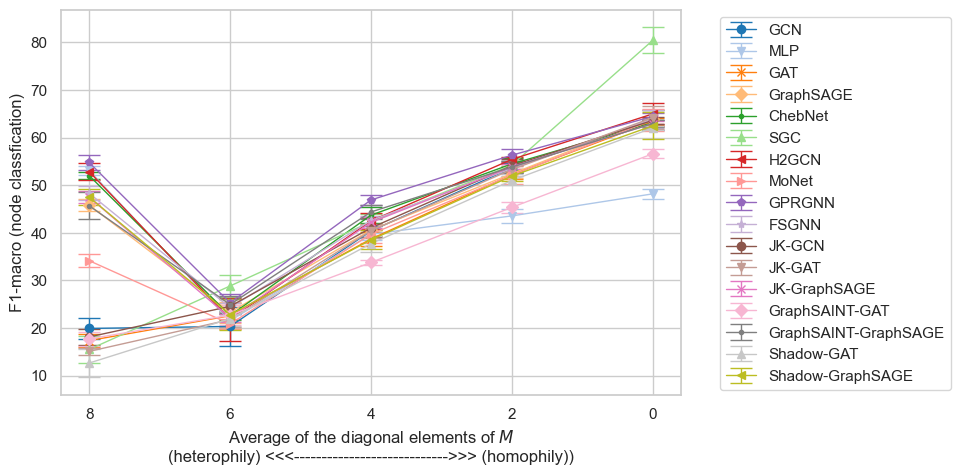

In [31]:
methods = ["GCN", "MLP", "GAT", "GraphSAGE", "ChebNet", "SGC", "H2GCN",
           "MoNet", "GPRGNN", "FSGNN", "JK-GCN", "JK-GAT", "JK-GraphSAGE",
           "GraphSAINT-GAT", "GraphSAINT-GraphSAGE", "Shadow-GAT", "Shadow-GraphSAGE"]
# methods = ["GCN", "MLP", "GAT", "GraphSAGE", "ChebNet", "SGC",
#               "H2GCN", "MoNet", "JK-GCN", "JK-GAT", "JK-GraphSAGE"]

base_dataset = "cora"
xlabel = "Average of the diagonal elements of $M$\n(heterophily) <<<---------------------------->>> (homophily))"
ylabel = 'F1-macro (node classfication)'
metric = "test_f1_macro"

adj, features, labels = load_data(base_dataset)
M, D, class_size, H, node_degree = feature_extraction(adj, features, labels)
num_classes = len(class_size)
print("num_classes:", num_classes)

k = num_classes
M_diag = 0  # 初期化
for i in range(k):
    M_diag += M[i, i]
M_diag /= k  # クラス内接続の平均を計算
base_value = int(M_diag * 10)  # 10段階に調整するために、元データの割合を整数で表現

# x_list = list(range(base_value - 9, base_value + 1))  # 元データのクラス内接続の割合に応じて、パラメータを生成
x_list = [8, 6, 4, 2, 0]
x_list = [str(x) for x in x_list]
print("x_list", x_list)  # = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]


plot_result(
    df_hetero_homo,
    methods,
    x_list,
    base_dataset,
    labels=[
        xlabel,
        ylabel],
    metric=metric)


## Hetero-Homo 修正版プロット(x=0調整後)
x=0の結果はattributeのx=0の結果を使用。２つの結果データを混ぜるので注意

In [32]:
# attribute実験結果データを読み込み
exp = "attribute"
split = "supervised"
result_path = f"{path_result}result_{exp}_{split}5.csv"

df_attribute = pd.read_csv(result_path)
print(df_attribute.shape)

df_hetero_homo_copy = df_hetero_homo.copy()
"""
hetero_homoデータの「dataset == GenCAT_cora_0_*」の部分を、attributeデータの「dataset == GenCAT_cora_0_*」の部分を
入れ替える
"""
print(df_hetero_homo_copy.query("dataset.str.contains('GenCAT_cora_0_')").shape)
print(df_attribute.query("dataset.str.contains('GenCAT_cora_0_')").shape)

df_hetero_homo_copy = df_hetero_homo_copy.query("not dataset.str.contains('GenCAT_cora_0_')")
print(df_hetero_homo_copy.shape)

# hetero_homoの結果の一部を、attributeの結果の一部に置き換える
df_hetero_homo_adjusted = pd.concat([df_hetero_homo_copy,
                                     df_attribute.query("dataset.str.contains('GenCAT_cora_0_')")])
print(df_hetero_homo_adjusted.shape)
df_hetero_homo_adjusted


(255, 63)
(51, 63)
(51, 63)
(204, 63)
(255, 63)


,cometml,dataset,exp,full_search_params,net,RPMAX,train_rate,val_rate,date,aggr,...,train_f1_micro_mean,train_f1_micro_std,val_acc_mean,val_acc_std,val_f1_macro_mean,val_f1_macro_std,val_f1_micro_mean,val_f1_micro_std,walk_length,weight_decay
0,True,GenCAT_cora_8_2,hetero_homo,True,GCN,3,0.6,0.2,2022-06-02 18:19:05.892,mean,...,50.097593,6.661346,30.750308,2.632341,22.401348,0.671360,30.750308,2.632341,2.0,0.0000
1,True,GenCAT_cora_8_1,hetero_homo,True,GCN,3,0.6,0.2,2022-06-02 18:18:54.462,mean,...,53.350460,2.743656,29.274293,2.566868,21.394127,3.036487,29.274293,2.566868,2.0,0.0000
2,True,GenCAT_cora_8_0,hetero_homo,True,GCN,3,0.6,0.2,2022-06-02 18:18:42.372,mean,...,49.203314,3.498264,24.169742,3.665354,20.592233,4.046971,24.169742,3.665354,2.0,0.0000
3,True,GenCAT_cora_6_2,hetero_homo,True,GCN,3,0.6,0.2,2022-06-02 18:18:28.344,mean,...,25.266071,6.086283,20.049200,7.005133,14.245811,5.977985,20.049200,7.005133,2.0,0.0005
4,True,GenCAT_cora_6_1,hetero_homo,True,GCN,3,0.6,0.2,2022-06-02 18:18:13.188,mean,...,35.076393,1.675465,24.846248,3.280930,21.644386,1.930813,24.846248,3.280930,2.0,0.0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,True,GenCAT_cora_0_1,attribute,True,Shadow-GAT,3,0.6,0.2,2022-06-02 17:51:49.678,mean,...,91.526157,0.627264,88.868389,0.484256,61.792835,0.712586,88.868389,0.484256,2.0,0.0000
239,True,GenCAT_cora_0_0,attribute,True,Shadow-GAT,3,0.6,0.2,2022-06-02 17:50:23.248,mean,...,93.013468,1.490695,90.098401,0.608825,69.033750,2.043627,90.098401,0.608825,2.0,0.0000
252,True,GenCAT_cora_0_2,attribute,True,Shadow-GraphSAGE,3,0.6,0.2,2022-06-02 18:12:27.551,mean,...,97.175493,3.555347,87.453875,1.851158,65.874373,2.132926,87.453875,1.851158,2.0,0.0000
253,True,GenCAT_cora_0_1,attribute,True,Shadow-GraphSAGE,3,0.6,0.2,2022-06-02 18:11:20.027,mean,...,96.238651,0.589632,89.175892,1.170129,64.044579,5.229971,89.175892,1.170129,2.0,0.0000


num_classes: 7
x_list ['8', '6', '4', '2', '0']


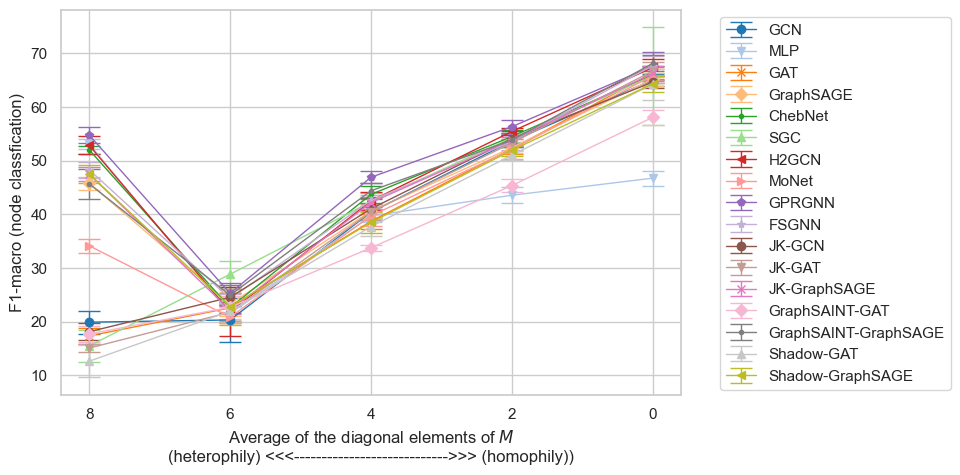

In [33]:
methods = ["GCN", "MLP", "GAT", "GraphSAGE", "ChebNet", "SGC", "H2GCN",
           "MoNet", "GPRGNN", "FSGNN", "JK-GCN", "JK-GAT", "JK-GraphSAGE",
           "GraphSAINT-GAT", "GraphSAINT-GraphSAGE", "Shadow-GAT", "Shadow-GraphSAGE"]
# methods = ["GCN", "MLP", "GAT", "GraphSAGE", "ChebNet", "SGC",
#               "H2GCN", "MoNet", "JK-GCN", "JK-GAT", "JK-GraphSAGE"]

base_dataset = "cora"
xlabel = "Average of the diagonal elements of $M$\n(heterophily) <<<---------------------------->>> (homophily))"
ylabel = 'F1-macro (node classfication)'
metric = "test_f1_macro"

adj, features, labels = load_data(base_dataset)
M, D, class_size, H, node_degree = feature_extraction(adj, features, labels)
num_classes = len(class_size)
print("num_classes:", num_classes)

k = num_classes
M_diag = 0  # 初期化
for i in range(k):
    M_diag += M[i, i]
M_diag /= k  # クラス内接続の平均を計算
base_value = int(M_diag * 10)  # 10段階に調整するために、元データの割合を整数で表現

# x_list = list(range(base_value - 9, base_value + 1))  # 元データのクラス内接続の割合に応じて、パラメータを生成
x_list = [8, 6, 4, 2, 0]
x_list = [str(x) for x in x_list]
print("x_list", x_list)  # = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]


plot_result(
    df_hetero_homo_adjusted,
    methods,
    x_list,
    base_dataset,
    labels=[
        xlabel,
        ylabel],
    metric=metric)


# Attribute Experiment

In [34]:
exp = "attribute"
split = "supervised"
result_path = f"{path_result}result_{exp}_{split}5.csv"

df_attribute = pd.read_csv(result_path)
print(df_attribute.shape)
df_attribute.head()[["dataset", "net", "test_acc_mean", "test_acc_std", "date"]]


(255, 63)


,dataset,net,test_acc_mean,test_acc_std,date
0,GenCAT_cora_rand_2,GCN,79.193900,2.193576,2022-06-02 16:45:23.654
1,GenCAT_cora_rand_1,GCN,82.187500,0.637888,2022-06-02 16:45:10.398
2,GenCAT_cora_rand_0,GCN,79.945799,0.903704,2022-06-02 16:44:57.021
3,GenCAT_cora_16_2,GCN,83.219178,1.118488,2022-06-02 16:44:43.674
4,GenCAT_cora_16_1,GCN,79.827586,2.044879,2022-06-02 16:44:31.345


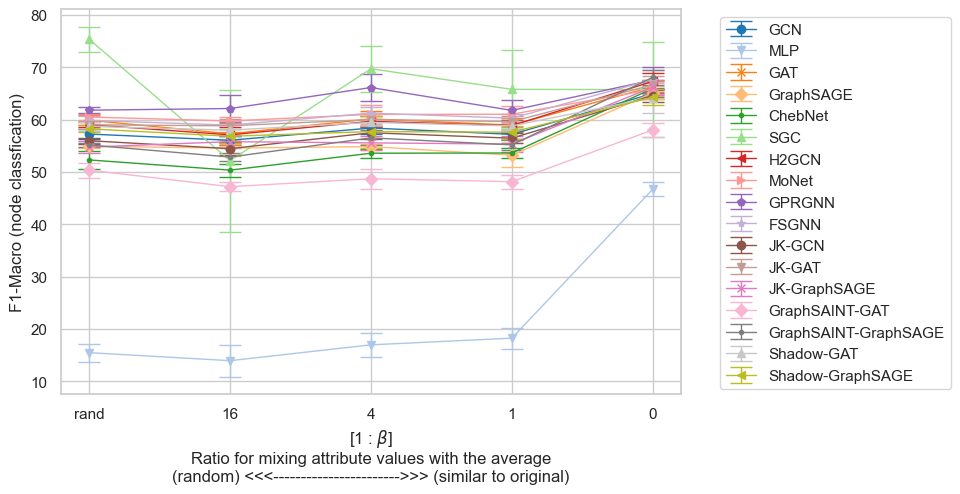

In [35]:
methods = ["GCN", "MLP", "GAT", "GraphSAGE", "ChebNet", "SGC", "H2GCN",
           "MoNet", "GPRGNN", "FSGNN", "JK-GCN", "JK-GAT", "JK-GraphSAGE",
           "GraphSAINT-GAT", "GraphSAINT-GraphSAGE", "Shadow-GAT", "Shadow-GraphSAGE"]

base_dataset = "cora"
metric = "test_f1_macro"
xlabel = '[1 : $\u03b2$]\nRatio for mixing attribute values with the average\n(random) <<<----------------------->>> (similar to original)'
ylabel = 'F1-Macro (node classfication)'

x_list = ["rand", 16, 4, 1, 0]
x_list = [str(x) for x in x_list]

plot_result(
    df_attribute,
    methods,
    x_list,
    base_dataset,
    labels=[
        xlabel,
        ylabel],
    metric=metric)


# Scalability Experiment

## Node & Edge Experiment

In [4]:
exp = "scalability_node_edge"
split = "supervised"
result_path = f"{path_result}result_{exp}_{split}5.csv"

df_scalability_node_edge = pd.read_csv(result_path)
print(df_scalability_node_edge.shape)
df_scalability_node_edge.head()[["dataset", "net", "test_acc_mean", "test_acc_std", "date"]]


(287, 63)


,dataset,net,test_acc_mean,test_acc_std,date
0,GenCAT_cora_96000_160000_2,GCN,89.921410,0.285759,2022-06-02 14:19:19.381
1,GenCAT_cora_96000_160000_1,GCN,89.907552,0.421609,2022-06-02 14:17:46.599
2,GenCAT_cora_96000_160000_0,GCN,90.166252,0.252766,2022-06-02 14:16:30.000
3,GenCAT_cora_48000_80000_0,GCN,88.925559,0.481858,2022-06-02 14:15:36.339
4,GenCAT_cora_48000_80000_1,GCN,89.631934,0.385412,2022-06-02 14:14:48.841


[('3000', '5000'), ('6000', '10000'), ('12000', '20000'), ('24000', '40000'), ('48000', '80000'), ('96000', '160000'), ('192000', '320000'), ('384000', '640000')]


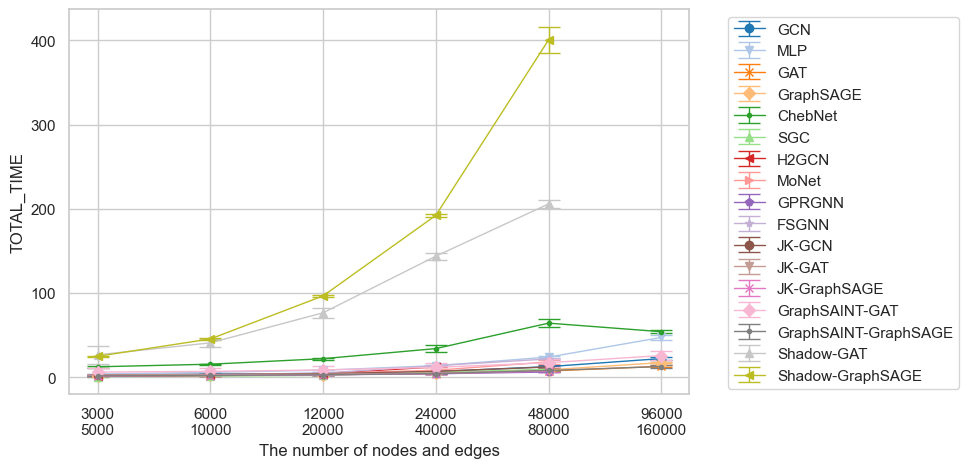

In [9]:
methods = ["GCN", "MLP", "GAT", "GraphSAGE", "ChebNet", "SGC", "H2GCN",
           "MoNet", "GPRGNN", "FSGNN", "JK-GCN", "JK-GAT", "JK-GraphSAGE",
           "GraphSAINT-GAT", "GraphSAINT-GraphSAGE", "Shadow-GAT", "Shadow-GraphSAGE"]
base_dataset = "cora"
metric = "total_time"
# ylabel = 'Accuracy (node classfication)'
ylabel = metric.upper()
xlabel = "The number of nodes and edges"
dataframe = df_scalability_node_edge

edge_list = 5000 * (2**np.array(range(8)))  # change edge
edge_list = [str(x) for x in edge_list]
node_list = 3000 * (2**np.array(range(8)))
node_list = [str(x) for x in node_list]
x_list = list(zip(node_list,edge_list))
print(x_list)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
markers = ['o', 'v', 'x', 'D', ".", "^", "<", ">", "p", "*"]
markers = markers+markers
colors = plt.cm.get_cmap("tab20").colors

for i, method in enumerate(methods):
  tmp = dataframe[dataframe["net"] == method]
  # tmp = tmp[tmp["dataset"]==f"GenCAT_cora_{x[i]}_0"]
  # 集約→datasetのiter部分を集計 GenCAT_{dataset}_{para}_{iter}
  # print(method,tmp.shape)
  test_acc_mean_list, test_acc_std_list = [],[]
  for x in x_list:
    tmp_filtered = tmp[tmp["dataset"].str.contains(f"GenCAT_{base_dataset}_{x[0]}_{x[1]}")]
    if len(tmp_filtered)>0:
      test_acc_mean = (tmp_filtered[f"{metric}_mean"] *
          tmp_filtered["RPMAX"].astype(int)).sum() / (len(tmp_filtered) * tmp_filtered.head(1)["RPMAX"].astype(int).values[0])
      test_acc_std = (tmp_filtered[f"{metric}_std"] *
                  tmp_filtered["RPMAX"].astype(int)).sum() / (len(tmp_filtered) * tmp_filtered.head(1)["RPMAX"].astype(int).values[0])
      if test_acc_mean==0:
        test_acc_mean = np.nan
    else:
      test_acc_mean = np.nan
      test_acc_std = np.nan
    test_acc_mean_list.append(test_acc_mean)
    test_acc_std_list.append(test_acc_std)
  # print(method, test_acc_mean_list, test_acc_std_list)
  x_list_ = [f"{x_[0]}\n{x_[1]}" for x_ in x_list]
  ax.errorbar(
      x_list_,
      test_acc_mean_list,
      yerr=test_acc_std_list,
      marker=markers[i],
      label=method,
      capthick=1,
      capsize=8,
      lw=1,
      color=colors[i])

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend(ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Class size Experiment

In [10]:
exp = "classsize"
split = "supervised"
result_path = f"{path_result}result_{exp}_{split}5.csv"

df_classsize = pd.read_csv(result_path)
print(df_classsize.shape)
df_classsize.head()[["dataset", "net", "test_acc_mean", "test_acc_std", "date"]]


(153, 63)


,dataset,net,test_acc_mean,test_acc_std,date
0,GenCAT_cora_flat_2,GCN,91.451415,0.230114,2022-06-02 17:05:16.810
1,GenCAT_cora_flat_1,GCN,91.266913,0.379115,2022-06-02 17:04:56.723
2,GenCAT_cora_flat_0,GCN,88.191882,0.690343,2022-06-02 17:04:36.591
3,GenCAT_cora_0.7_2,GCN,94.096026,0.213040,2022-06-02 17:04:21.555
4,GenCAT_cora_0.7_1,GCN,95.625297,0.168119,2022-06-02 17:04:05.464


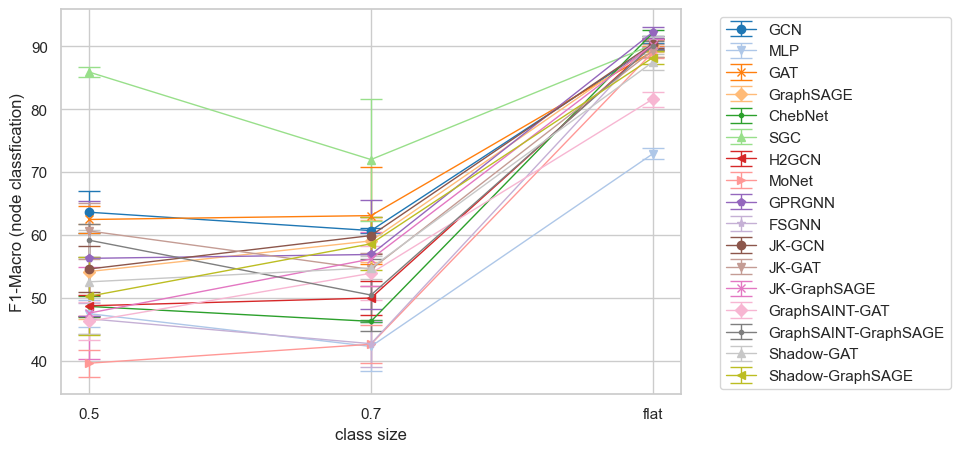

In [11]:
methods = ["GCN", "MLP", "GAT", "GraphSAGE", "ChebNet", "SGC", "H2GCN",
           "MoNet", "GPRGNN", "FSGNN", "JK-GCN", "JK-GAT", "JK-GraphSAGE",
           "GraphSAINT-GAT", "GraphSAINT-GraphSAGE", "Shadow-GAT", "Shadow-GraphSAGE"]

base_dataset = "cora"
metric = "test_f1_macro"
xlabel = "class size"
ylabel = 'F1-Macro (node classfication)'

x_list = [0.5, 0.7, "flat"]
x_list = [str(x) for x in x_list]
plot_result(df_classsize, methods, x_list, base_dataset, labels=[xlabel, ylabel], metric=metric)


[('3000', '5000'), ('6000', '10000'), ('12000', '20000')]


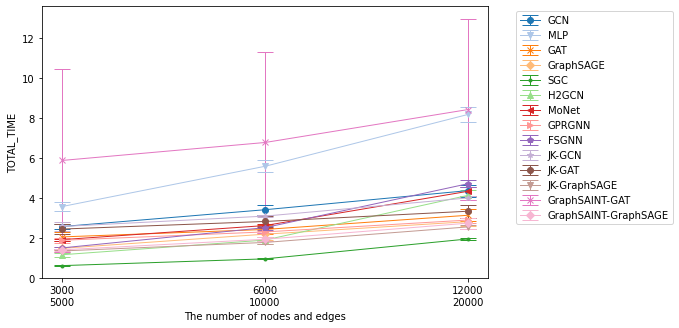

In [10]:
# 確認

# methods = ["GCN", "MLP", "GAT", "GraphSAGE", "ChebNet", "SGC", "H2GCN",
#            "MoNet", "GPRGNN", "FSGNN", "JK-GCN", "JK-GAT", "JK-GraphSAGE",
#            "GraphSAINT-GAT", "GraphSAINT-GraphSAGE", "Shadow-GAT", "Shadow-GraphSAGE"]
methods = ["GCN", "MLP", "GAT", "GraphSAGE", "SGC", "H2GCN",
           "MoNet", "GPRGNN", "FSGNN", "JK-GCN", "JK-GAT", "JK-GraphSAGE",
           "GraphSAINT-GAT", "GraphSAINT-GraphSAGE"]

base_dataset = "cora"
metric = "total_time"
# ylabel = 'Accuracy (node classfication)'
ylabel = metric.upper()
xlabel = "The number of nodes and edges"
dataframe = df_scalability_node_edge

edge_list = 5000 * (2**np.array(range(3)))  # change edge
edge_list = [str(x) for x in edge_list]
node_list = 3000 * (2**np.array(range(3)))
node_list = [str(x) for x in node_list]
x_list = list(zip(node_list, edge_list))
print(x_list)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
markers = ['o', 'v', 'x', 'D', ".", "^", "<", ">", "p", "*"]
markers = markers + markers
colors = plt.cm.get_cmap("tab20").colors

for i, method in enumerate(methods):
  tmp = dataframe[dataframe["net"] == method]
  # tmp = tmp[tmp["dataset"]==f"GenCAT_cora_{x[i]}_0"]
  # 集約→datasetのiter部分を集計 GenCAT_{dataset}_{para}_{iter}
  # print(method,tmp.shape)
  test_acc_mean_list, test_acc_std_list = [], []
  for x in x_list:
    tmp_filtered = tmp[tmp["dataset"].str.contains(f"GenCAT_{base_dataset}_{x[0]}_{x[1]}")]
    if len(tmp_filtered) > 0:
      test_acc_mean = (tmp_filtered[f"{metric}_mean"] *
                       tmp_filtered["RPMAX"].astype(int)).sum() / (len(tmp_filtered) * tmp_filtered.head(1)["RPMAX"].astype(int).values[0])
      test_acc_std = (tmp_filtered[f"{metric}_std"] *
                      tmp_filtered["RPMAX"].astype(int)).sum() / (len(tmp_filtered) * tmp_filtered.head(1)["RPMAX"].astype(int).values[0])
      if test_acc_mean == 0:
        test_acc_mean = np.nan
    else:
      test_acc_mean = np.nan
      test_acc_std = np.nan
    test_acc_mean_list.append(test_acc_mean)
    test_acc_std_list.append(test_acc_std)
  # print(method, test_acc_mean_list, test_acc_std_list)
  x_list_ = [f"{x_[0]}\n{x_[1]}" for x_ in x_list]
  ax.errorbar(
      x_list_,
      test_acc_mean_list,
      yerr=test_acc_std_list,
      marker=markers[i],
      label=method,
      capthick=1,
      capsize=8,
      lw=1,
      color=colors[i])

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend(ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
